In [1]:
try:
    import bitsandbytes
except ModuleNotFoundError:
    !pip install bitsandbytes
    
from transformers import __version__ as transformers_version
if not transformers_version.startswith('4.'): 
    !pip install transformers --upgrade
elif float(transformers_version.split('.')[1]) < 4.3: 
    !pip install transformers==transformers@">=4.3"
    
import psutil
available_memory = psutil.virtual_memory().available / (1024 ** 2)
if available_memory < 18000:
    print("Possibly not enough mem for llava; use free option w/ 2 gpus on kaggle")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.4 MB/s eta 0:00:0000:0100:01


In [2]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers.models.llama.modeling_llama import LlamaSdpaAttention, LlamaMLP, apply_rotary_pos_emb, repeat_kv
from transformers.models.clip.modeling_clip import CLIPAttention, CLIPMLP, CLIPVisionEmbeddings

import torch
from torch import nn

import requests
from PIL import Image
from collections import OrderedDict
from typing import List, Optional, Tuple, Union
from itertools import product

MODEL_ID = "llava-hf/llava-1.5-7b-hf"

2024-04-12 20:10:47.672119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 20:10:47.672270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 20:10:47.848482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = LlavaForConditionalGeneration.from_pretrained(MODEL_ID, 
                                                      torch_dtype=torch.float16, 
                                                      low_cpu_mem_usage=True,
                                                      load_in_4bit=False, 
                                                      device_map="auto")

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [4]:
#overwrite forward function to output individual attention head outputs 

def forward(self, hidden_states: torch.Tensor, attention_mask: Optional[torch.Tensor] = None, position_ids: Optional[torch.LongTensor] = None, 
            past_key_value=None, output_attentions: bool = False, use_cache: bool = False, 
            cache_position: Optional[torch.LongTensor] = None,) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    '''modified to output individual attention head output ontop'''
    if output_attentions:
        return super().forward(hidden_states=hidden_states, attention_mask=attention_mask, position_ids=position_ids, past_key_value=past_key_value,
                               output_attentions=output_attentions, use_cache=use_cache, cache_position=cache_position,)

    bsz, q_len, _ = hidden_states.size()
    
    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

    cos, sin = self.rotary_emb(value_states, position_ids)
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

    # In case static cache is used, it is an instance attribute.
    past_key_value = getattr(self, "past_key_value", past_key_value)

    if past_key_value is not None:
        # sin and cos are specific to RoPE models; cache_position needed for the static cache
        cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
        key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)
    
    causal_mask = attention_mask
    # if attention_mask is not None and cache_position is not None:
    if attention_mask is not None:
        causal_mask = causal_mask[:, :, :, : key_states.shape[-2]]

    # SDPA with memory-efficient backend is currently (torch==2.1.2) bugged with non-contiguous inputs with custom attn_mask,
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    if query_states.device.type == "cuda" and causal_mask is not None:
        query_states = query_states.contiguous()
        key_states = key_states.contiguous()
        value_states = value_states.contiguous()
    
    attn_output = torch.nn.functional.scaled_dot_product_attention(
        query_states,
        key_states,
        value_states,
        attn_mask=None,
        is_causal=True,
        dropout_p=self.attention_dropout if self.training else 0.0,)

    attn_output = attn_output.transpose(1, 2).contiguous()
    attn_output = attn_output.view(bsz, q_len, self.hidden_size)
    
    #output per head
    n_heads = self.num_heads
    h_size = self.hidden_size
    wo_weights = self.o_proj.weight.T.reshape(n_heads, -1, h_size)  #weights per head- shape = (n_heads, in_shape (head dim), out_shape (hidden sze))
    per_head_context_vector = attn_output.transpose(1,2).reshape(bsz, n_heads, -1, q_len).transpose(2,3)
    output_per_head = per_head_context_vector@wo_weights  #shape = (bsz, n_heads, seq len, hidden dim)
    
    #original stacked output
    attn_output = self.o_proj(attn_output)
    
    return attn_output, None, output_per_head

for layer in model.language_model.model.layers:
    layer.self_attn.forward = forward.__get__(layer.self_attn, LlamaSdpaAttention)

In [5]:
def format_prompt(prompt):
    return "USER: <image>\n" + prompt + "\nASSISTANT:"

def forward_pass(prompt, img_url, model):
    formatted_prompt = format_prompt(prompt)
    if 'http' in img_url:
        raw_image = Image.open(requests.get(img_url, stream=True).raw)
    else:
        raw_image = Image.open(img_url)
    
    inputs = processor(formatted_prompt, raw_image, return_tensors='pt').to(0, torch.float16)
    output = model.generate(**inputs, max_new_tokens=1, do_sample=False, return_dict_in_generate=True, use_cache=False, output_scores=True)
    logits = output.scores[0]
    logits = logits.cpu()
    decoded_response = processor.decode(output[0][0, inputs['input_ids'].shape[1]:], skip_special_tokens=True) #only 1st dim; assuming non batched
    
    #print(decoded_response)
    return decoded_response, logits

def get_activations(prompt, img_url, model):
    activations = OrderedDict()
    registered_hooks = []

    def hook(module, input, output):
        for name, submodule in model.named_modules():
            if submodule is module:
                layer_name = module.__class__.__name__ + "_" + name
                if 'LlamaSdpaAttention' in layer_name:
                    activations[layer_name] = output[2].detach().cpu()
                else:
                    activations[layer_name] = output[0].detach().cpu()
                    
    for name, module in model.language_model.named_modules():
        if isinstance(module, LlamaSdpaAttention) or isinstance(module, LlamaMLP):
            hook_handle = module.register_forward_hook(hook)
            registered_hooks.append(hook_handle)

    for name, module in model.vision_tower.vision_model.named_modules():
        if isinstance(module, CLIPAttention) or isinstance(module, CLIPMLP):
            hook_handle = module.register_forward_hook(hook)
            registered_hooks.append(hook_handle)        

    for name, module in model.multi_modal_projector.named_modules():
        if 'linear' in name:
            hook_handle = module.register_forward_hook(hook)
            registered_hooks.append(hook_handle)
    
    decoded_response, logits = forward_pass(prompt, img_url, model)
    
    for hook_handle in registered_hooks:
        hook_handle.remove()
    
    return activations, logits

#not using gaussion noise here atm
def corrupted_run_gaussian_noise(prompt, img_url, model, std):
    model.std = std
    
    def corrupted_embedding_forward(self, pixel_values):
        batch_size = pixel_values.shape[0]
        patch_embeds = self.patch_embedding(pixel_values)  # shape = [*, width, grid, grid]
        patch_embeds = patch_embeds.flatten(2).transpose(1, 2)

        class_embeds = self.class_embedding.expand(batch_size, 1, -1)
        embeddings = torch.cat([class_embeds, patch_embeds], dim=1)
        embeddings = embeddings + self.position_embedding(self.position_ids) + torch.randn_like(embeddings) * self.std
        return embeddings
    
    original_embedding_forward = model.vision_tower.vision_model.embeddings.forward
    model.vision_tower.vision_model.embeddings.forward = corrupted_embedding_forward
    
    decoded_response, logits = forward_pass(prompt, img_url, model)
    
    model.vision_tower.vision_model.embeddings.forward = original_embedding_forward.__get__(model.vision_tower.vision_model.embeddings, 
                                                                                            CLIPVisionEmbeddings)
    
    return logits

def restored_run(prompt, img_url, model, activations, head_to_restore: Tuple[int, int], token_to_restore: Optional[int] = None):
    '''head_to_restore is of format (layer, head number), head number is zero indexed'''
    layer_idx = str(head_to_restore[0])
    head_idx = head_to_restore[1]
    
    for name, module in model.named_modules():
        if isinstance(module, LlamaSdpaAttention) and (layer_idx in name):
            layer_name = module.__class__.__name__ + "_" + name
            module_to_hook = module
            break
            
    clean_output = activations[layer_name]
    if token_to_restore == None:
        clean_output_specific_head = clean_output[:, head_idx, :, :]
    else:
        clean_output_specific_head = clean_output[:, head_idx, token_to_restore, :]
    
    def patch_head(module, input, output):
        output = list(output)
        corrupted_output_all_heads = output[2]
        if token_to_restore == None:
            corrupted_output_specific_head = corrupted_output_all_heads[:, head_idx, :, :]
            output[0] -= corrupted_output_specific_head
            output[0] += clean_output_specific_head.to(output[0].device)
        else:
            corrupted_output_specific_head = corrupted_output_all_heads[:, head_idx, token_to_restore, :]
            output[0][:, token_to_restore, :] -= corrupted_output_specific_head
            output[0][:, token_to_restore, :] += clean_output_specific_head.to(output[0].device)
        return output[0], output[1], output[2]
                
    hook_handle = module_to_hook.register_forward_hook(patch_head)
    decoded_response, logits = forward_pass(prompt, img_url, model)
    hook_handle.remove()
    
    return decoded_response, logits

In [6]:
CLEAN = "/kaggle/input/extract-color/extract_color.png"
CORRUPTED_GREEN = '/kaggle/input/extract-color/extract_color_green.png'
CORRUPTED_BLUE = '/kaggle/input/extract-color/extract_color_patched_blue.png'

extract_color_prompt = 'Which color is the odd color out? Respond in one word'

RED_IDX = 4367 #indices of tokens in vocab
GREEN_IDX = 7646
BLUE_IDX = 10924

In [7]:
activations, clean_logits = get_activations(extract_color_prompt, CLEAN, model)
_, corrupted_green_logits = forward_pass(extract_color_prompt, CORRUPTED_GREEN, model)
_, corrupted_blue_logits = forward_pass(extract_color_prompt, CORRUPTED_BLUE, model)

In [8]:
patched_logits_dict_green = {t: None for t in product(range(32), range(32))}
patched_logits_dict_blue = {t: None for t in product(range(32), range(32))}

for attn_head in patched_logits_dict_green.keys():
    _, logits = restored_run(extract_color_prompt, CORRUPTED_GREEN, model, activations, head_to_restore=attn_head)
    patched_logits_dict_green[attn_head] = logits
    torch.cuda.empty_cache()

for attn_head in patched_logits_dict_blue.keys():
    _, logits = restored_run(extract_color_prompt, CORRUPTED_BLUE, model, activations, head_to_restore=attn_head)
    patched_logits_dict_blue[attn_head] = logits
    torch.cuda.empty_cache()

<Axes: >

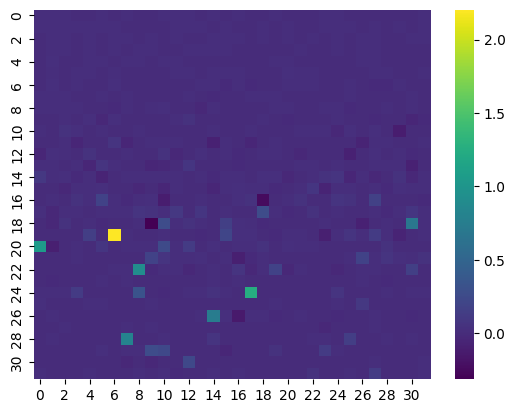

In [18]:
import seaborn as sns
import numpy as np

heatmap_data = np.zeros((32, 32))
for row in range(32):
    for col in range(32):
        key = (row, col)
        logit_diff_red = patched_logits_dict_green[key][0, RED_IDX] - corrupted_green_logits[0, RED_IDX]
        heatmap_data[row, col] = logit_diff_red
sns.heatmap(heatmap_data, cmap="viridis")

<Axes: >

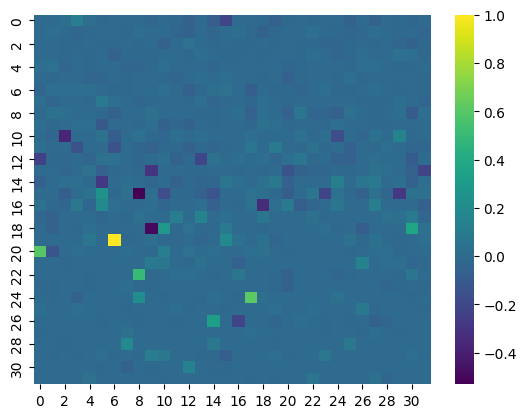

In [19]:
heatmap_data = np.zeros((32, 32))
for row in range(32):
    for col in range(32):
        key = (row, col)
        logit_diff_red = patched_logits_dict_blue[key][0, RED_IDX] - corrupted_blue_logits[0, RED_IDX]
        heatmap_data[row, col] = logit_diff_red
sns.heatmap(heatmap_data, cmap="viridis")

<Axes: >

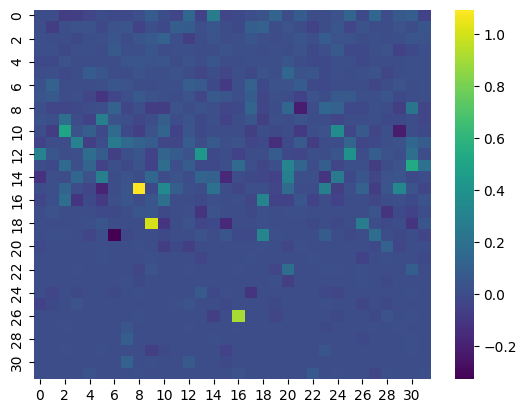

In [20]:
heatmap_data = np.zeros((32, 32))
for row in range(32):
    for col in range(32):
        key = (row, col)
        logit_diff_red = patched_logits_dict_blue[key][0, BLUE_IDX] - corrupted_blue_logits[0, BLUE_IDX]
        heatmap_data[row, col] = logit_diff_red
sns.heatmap(heatmap_data, cmap="viridis")